# New York Taxi Fare Prediction with XGBoost

Doanload datasets at [New York City Taxi Fare Prediction](https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction/data)

In [1]:
import numpy as np 
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import inspect
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import time
from joblib import dump, load
from scipy import stats

## Dataset input

Read a subset of the training dataset since it's very big, and takes long time to read and train.

In [2]:
train_file = '../new-york-city-taxi-fare-prediction/train.csv'
test_file = '../new-york-city-taxi-fare-prediction/test.csv'
if os.path.isfile(train_file) == False or os.path.isfile(test_file) == False:
    print("Please download data at https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction/data")
    exit()

In [3]:
# train: 55423480 rows; 5+ GB
# test: 9914 rows
train = pd.read_csv('../new-york-city-taxi-fare-prediction/train.csv', nrows=100000)
test = pd.read_csv('../new-york-city-taxi-fare-prediction/test.csv')

In [4]:
train.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

## Feature engineering

### Clean the data

In [5]:
train = train.query('fare_amount > 0')
train.dropna(inplace = True)
test.dropna(inplace = True)

 ### Manhattan distance
 The most important feature is the distance.

In [6]:
train['manhattan_distance'] = np.abs(train['pickup_longitude'] - train['dropoff_longitude']) + np.abs(train['pickup_latitude'] - train['dropoff_latitude'])
test['manhattan_distance'] = np.abs(test['pickup_longitude'] - test['dropoff_longitude']) + np.abs(test['pickup_latitude'] - test['dropoff_latitude'])                              

### Transform the skewed data

Text(0, 0.5, 'Count')

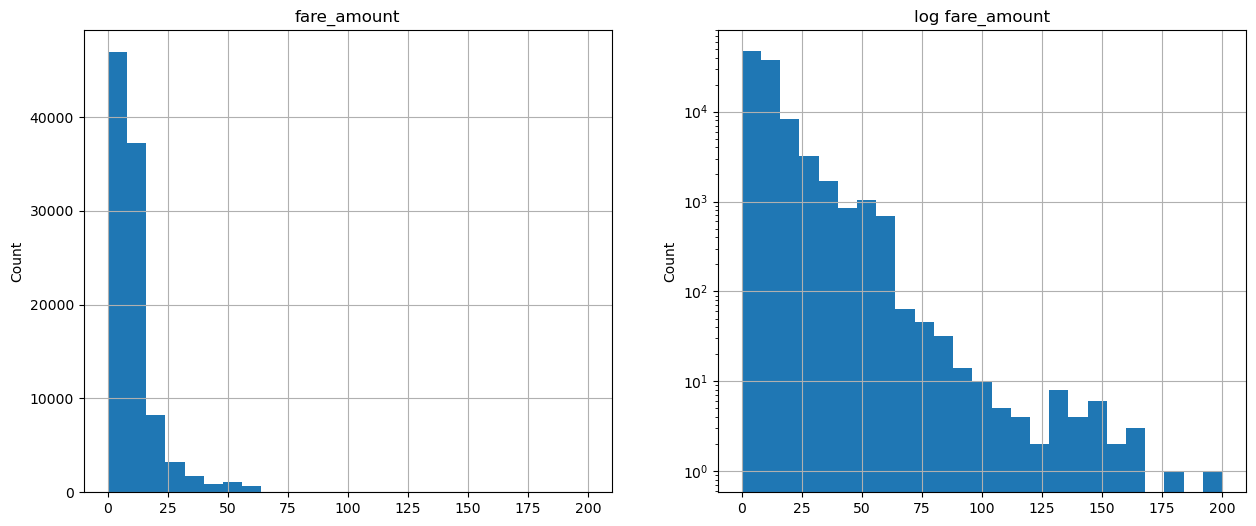

In [7]:
fare_amount = train['fare_amount']
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
plt1 = fare_amount.hist(ax=axes[0], bins = 25)
plt1.set_title('fare_amount')
plt1.set_ylabel('Count')

plt2 = fare_amount.hist(ax=axes[1], bins = 25, log=True)
plt2.set_title('log fare_amount')
plt2.set_ylabel('Count')

In [8]:
print('Transform: Select the lowest skew')
print(fare_amount.skew())
print(np.log(fare_amount).skew())
print(np.sqrt(fare_amount).skew())
print(pd.Series(stats.boxcox(fare_amount)[0]).skew())

Transform: Select the lowest skew
3.5535774522337804
0.7962900811475383
1.8967189528802666
-0.41701183308103984


In [9]:
def transform(df):
    # Use log transformation to remove skewness    
    df['log_fare_amount'] = np.log(df['fare_amount'])
    return df
    
train = transform(train)

Text(0, 0.5, 'Log Count')

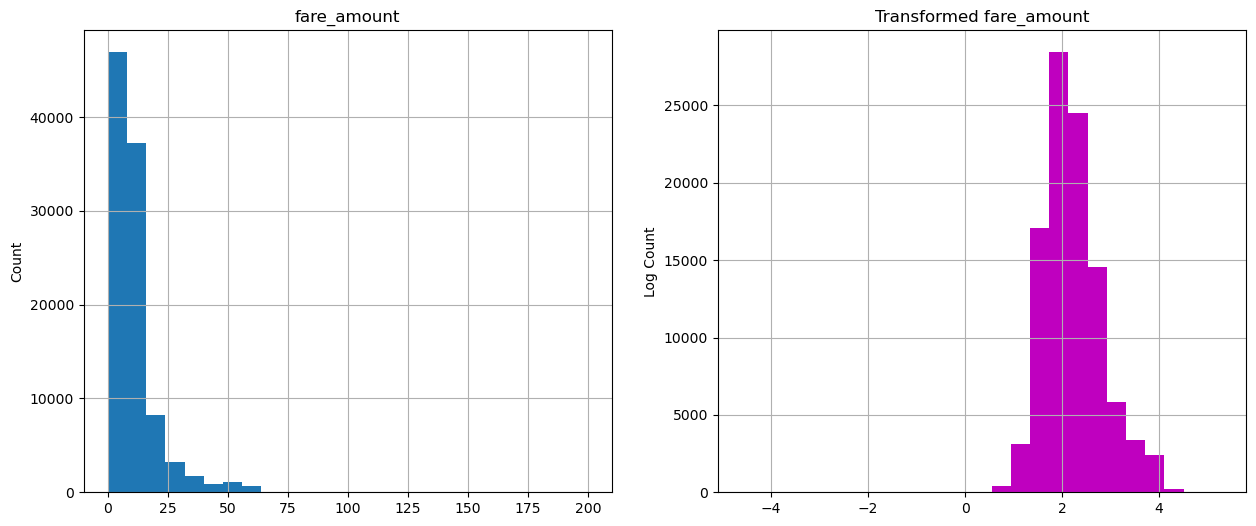

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

plt1 = train.fare_amount.hist(ax=axes[0], bins = 25)
plt1.set_title('fare_amount')
plt1.set_ylabel('Count')

plt2 = train.log_fare_amount.hist(ax=axes[1], bins = 25, color = 'm')
plt2.set_title('Transformed fare_amount')
plt2.set_ylabel('Log Count')

### Drop the unused columns

key and pickup_datetime are assumed negligible. Therefore drop them from the training and testing datasets.

In [11]:
#fare_amount = train['fare_amount']
ytrain = train['log_fare_amount']
xtrain = train.drop(columns = ['fare_amount', 'log_fare_amount', 'key', 'pickup_datetime'], inplace = False)   
test.drop(columns = ['key', 'pickup_datetime'], inplace = True, axis=1) 

In [12]:
xtrain.head(4)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,manhattan_distance
0,-73.844311,40.721319,-73.841610,40.712278,1,0.011742
1,-74.016048,40.711303,-73.979268,40.782004,1,0.107481
2,-73.982738,40.761270,-73.991242,40.750562,2,0.019212
3,-73.987130,40.733143,-73.991567,40.758092,1,0.029386


In [13]:
ytrain.head(4)

0    1.504077
1    2.827314
2    1.740466
3    2.041220
Name: log_fare_amount, dtype: float64

In [14]:
test.head(4)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,manhattan_distance
0,-73.973320,40.763805,-73.981430,40.743835,1,0.028080
1,-73.986862,40.719383,-73.998886,40.739201,1,0.031841
2,-73.982524,40.751260,-73.979654,40.746139,1,0.007991
3,-73.981160,40.767807,-73.990448,40.751635,1,0.025460
